## Bibliotecas utilizadas

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import math

## Extração dos dados

In [2]:
def extract_data(file):

    arq = open(file)
    content = arq.readlines()
    arq.close()
    
    index = content.index('NODE_COORD_SECTION\n')
    eof = content.index('EOF\n')

    data = content[index+1:eof]
    
    return data

In [3]:
data = extract_data('berlin52.tsp')

In [4]:
data[:5]

['1 565.0 575.0\n',
 '2 25.0 185.0\n',
 '3 345.0 750.0\n',
 '4 945.0 685.0\n',
 '5 845.0 655.0\n']

## Classes

In [5]:
class DeliveryPlace:
    
    def __init__(self, id_, x_, y_):
        
        self.id = id_
        self.x = x_
        self.y = y_

In [6]:
def generate_delivery_places(data):

    delivery_places = []

    for del_place in data:

        del_place = del_place.replace("  ", " ")
        del_place = del_place.strip().split(" ")
        
        id_place = int(del_place[0]) - 1
        coord_x = float(del_place[1])
        coord_y = float(del_place[2].replace("\n", ""))

        delivery_places.append(DeliveryPlace(id_place, coord_x, coord_y))

    return delivery_places

In [7]:
delivery_places = generate_delivery_places(data)

In [8]:
for place in delivery_places[:3]:
    print(place.id, place.x, place.y)

0 565.0 575.0
1 25.0 185.0
2 345.0 750.0


In [9]:
class Depot:
    
    def __init__(self, delivery_places, id_):
        
        self.id = id_
        self.x = np.mean([point.x for point in delivery_places])
        self.y = np.mean([point.y for point in delivery_places])

In [10]:
id_depot = len(delivery_places)
depot = Depot(delivery_places, id_depot)
print(depot.x, depot.y)

758.4615384615385 564.9038461538462


In [11]:
id_depot

52

In [12]:
places = delivery_places + [depot]
print(places[-3:])

[<__main__.DeliveryPlace object at 0x7f25c9c4f490>, <__main__.DeliveryPlace object at 0x7f25c9c4f4f0>, <__main__.Depot object at 0x7f25c9c4f880>]


## Matriz de distancias

In [13]:
def calculate_distance(p1, p2):
    
    delta_x = p1.x - p2.x
    delta_y = p1.y - p2.y
    
    distance = np.sqrt(delta_x**2 + delta_y**2)
    
    return distance

In [14]:
def generate_distance_matrix(places):
    
    num_places = len(places)
    
    distances = np.zeros((num_places, num_places))
    
    
    for i in range(num_places):
        for k in range(1, num_places):
            
            p1 = places[i]
            p2 = places[k]
            
            index_1 = p1.id
            index_2 = p2.id
            
            distance = calculate_distance(p1, p2)
            
            distances[index_1, index_2] = distance
            distances[index_2, index_1] = distance
    

    return distances

In [15]:
distance_matrix = generate_distance_matrix(places)

## Partição do espaço

In [16]:
def get_key_delivery_places(num_vehicles, delivery_places, depot):
    
    key_delivery_places = []
    mean_places = [depot]
    virtual_places = []
    places = delivery_places.copy()
    
    for i in range(num_vehicles):
        
        furthest_place = -1
        furthest_distance = 0
    
        virtual_place_x = np.mean([place.x for place in mean_places])
        virtual_place_y = np.mean([place.y for place in mean_places])
        virtual_place = DeliveryPlace(i, virtual_place_x, virtual_place_y)
        virtual_places.append(virtual_place)
        
        for j in range(len(places)):
            
            distance = calculate_distance(virtual_place, places[j])
            if distance > furthest_distance:
                
                furthest_place = j
                furthest_distance = distance
                
        mean_places.append(places[furthest_place])
        key_delivery_places.append(places[furthest_place])
        places.pop(furthest_place)
            
        
    return key_delivery_places, virtual_places

In [20]:
key_delivery_places, virtual_places = get_key_delivery_places(5, delivery_places, depot)

In [21]:
def show_places(delivery_places, key_delivery_places, depot, virtual):

    plt.figure(figsize = (16,10))
    
    for place in delivery_places:

        plt.scatter(place.x, place.y, color = "b")

    i = 0
    for place in key_delivery_places:

        plt.scatter(place.x, place.y, color = "y")
        plt.text(place.x, place.y, i)
        i+=1
        
    i = 0
    for place in virtual:

        plt.scatter(place.x, place.y, color = "g")
        plt.text(place.x, place.y, i)
        i+=1

    plt.scatter(depot.x, depot.y, color = "r")
        
    plt.xlabel("Coordenada x", fontsize = 16)
    plt.ylabel("Coordenada y", fontsize = 16)
    plt.title("Locais chaves e locais virtuais", fontsize = 22)
    plt.show()

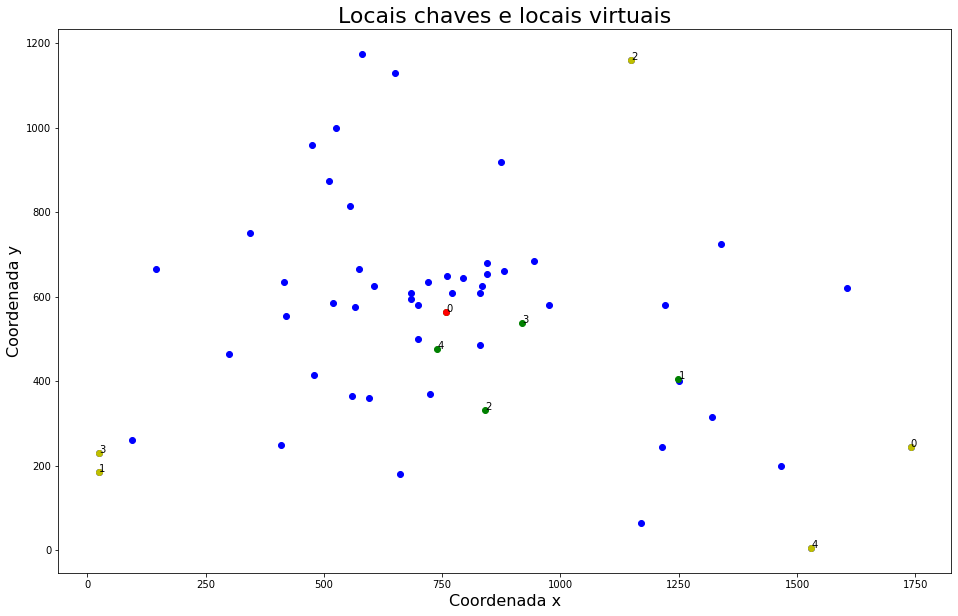

In [22]:
show_places(delivery_places, key_delivery_places, depot, virtual_places)

In [22]:
def calculate_slope(place1, place2):

    delta_x = place2.x - place1.x
    delta_y = place2.y - place1.y

    slope = math.atan2(delta_y, delta_x)

    slope_degrees = math.degrees(slope)%360

    return slope_degrees

In [23]:
def find_interval(value, intervals):
    
    for i in range(len(intervals) - 1):
        if intervals[i] <= value < intervals[i + 1]:
            return i 

    return len(intervals) - 1

In [24]:
def space_partition(delivery_places, key_delivery_places, depot):
    
    partitions_indexes = [[depot.id] for _ in range(len(key_delivery_places))]
    partitions_objects = [[depot] for _ in range(len(key_delivery_places))]
    partitions_slopes = []
    slopes_key_places = []
    slopes_delivery_places = []
    
    for place in key_delivery_places:
        slopes_key_places.append(calculate_slope(depot, place))

    slopes_key_places.sort()
        
    for place in delivery_places:
        slopes_delivery_places.append(calculate_slope(depot, place))
        
    for i in range(len(slopes_key_places)-1):
        partitions_slopes.append((slopes_key_places[i] + slopes_key_places[i+1])/2)
    
    if (slopes_key_places[-1] + slopes_key_places[0]) > 360:
        partitions_slopes.append(((slopes_key_places[-1] + slopes_key_places[0])%360)/2)
    else:
        partitions_slopes.append((slopes_key_places[-1] + (360 - slopes_key_places[-1] + slopes_key_places[0])/2))
    
    
    partitions_slopes.sort()
    
    for j in range(len(delivery_places)):
        
        id_partition = find_interval(slopes_delivery_places[j], partitions_slopes)
        partitions_indexes[id_partition].append(j)
        partitions_objects[id_partition].append(delivery_places[j])
    
    return partitions_indexes, partitions_objects

In [25]:
partitions_indexes, partitions_objects = space_partition(delivery_places, key_delivery_places, depot)

In [53]:
def show_partition(delivery_places, partitions, depot):
    
    plt.figure(figsize = (16,10))
    
    colors = ['blue', 'yellow', "green", 'brown', 'cyan', 'orange', 'black']
    
    for i in range(len(partitions)):
        for j in partitions[i]:
            plt.scatter(delivery_places[j].x, delivery_places[j].y, color = colors[i])

    plt.scatter(depot.x, depot.y, color = "r")
        
    plt.xlabel("Coordenada x", fontsize = 16)
    plt.ylabel("Coordenada y", fontsize = 16)
    plt.title("Partições geradas", fontsize = 22)
    plt.show()

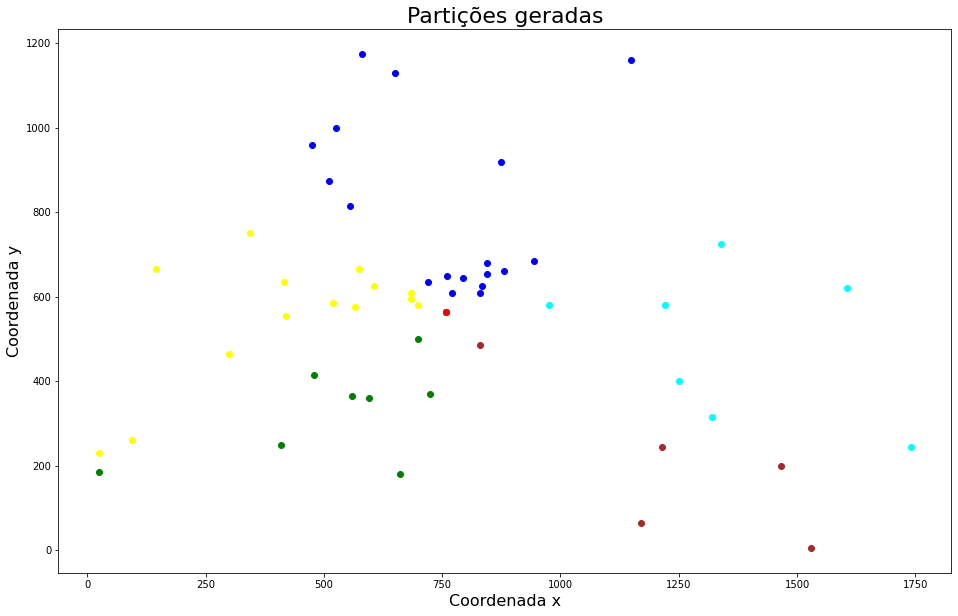

In [64]:
 show_partition(places, partitions_indexes, depot)

## Geração de rotas

In [28]:
def generate_graph(distance_matrix):
    
    graph = nx.Graph()

    for i in range(0, len(distance_matrix)):
        for j in range(i+1, len(distance_matrix)):
            graph.add_edge(i, j, weight=distance_matrix[i, j])
            
    return graph

In [29]:
def mst_heuristic(distance_matrix, partitions_indexes):
    
    num_vertices = len(distance_matrix)
    
    graph = generate_graph(distance_matrix)
    mst = nx.minimum_spanning_tree(graph)
    degrees = dict(mst.degree())
    
    # Vertex with maximum degree and its nearest neighbor
    vertex_with_max_degree = max(degrees, key=degrees.get)
    min_edge = min(graph.edges(vertex_with_max_degree, data=True), key=lambda edge: edge[2].get('weight'))
    
    # Initial path and cost
    cost = min_edge[2]["weight"]
    path = [vertex_with_max_degree, min_edge[1]] 
    
    available_vertices = [i for i in range(num_vertices)]
    available_vertices.remove(vertex_with_max_degree)
    available_vertices.remove(min_edge[1])
    
    roots = [v for v in mst.nodes() if mst.degree(v) == 1]
    
    while len(path) != num_vertices:

        first_vertex = path[0]
        last_vertex = path[-1]
        
        neighbors_first = list(mst.neighbors(path[0]))
        neighbors_last = list(mst.neighbors(path[-1]))
        
        add_at_beginning = True
        smallest_vertex = available_vertices[0]
        current_cost = distance_matrix[first_vertex, smallest_vertex]
        
        if distance_matrix[last_vertex, smallest_vertex] < current_cost:
            current_cost = distance_matrix[last_vertex, smallest_vertex]
            add_at_beginning = False
        
        if set(roots + neighbors_first + neighbors_last).difference(set(path)) == set():
            
            pos = -1
            current_cost = float('inf')
            
            for i in range(len(path)-1):
                
                estimated_cost = distance_matrix[path[i], smallest_vertex] + distance_matrix[path[i+1], smallest_vertex]
                if estimated_cost < current_cost:
                    current_cost = estimated_cost
                    pos = i
                    
            available_vertices.remove(smallest_vertex)
            path.insert(pos, smallest_vertex)
               
        else:
            for vertex in set(roots + neighbors_first).difference(set(path)):

                if distance_matrix[first_vertex, vertex] < current_cost:
                    current_cost = distance_matrix[first_vertex, vertex]
                    smallest_vertex = vertex

            for vertex in set(roots + neighbors_last).difference(set(path)):

                if distance_matrix[last_vertex, vertex] < current_cost:
                    current_cost = distance_matrix[last_vertex, vertex]
                    smallest_vertex = vertex
                    add_at_beginning = False
        
            if smallest_vertex in roots:
                new_root = list(mst.neighbors(smallest_vertex))[0]
                roots.remove(smallest_vertex)

                if new_root not in path:
                    roots.append(new_root)

            if add_at_beginning:
                path.insert(0, smallest_vertex)
            else:
                path.append(smallest_vertex)

            available_vertices.remove(smallest_vertex)
    
    path.append(path[0])
    
    total_distance = 0
    for i in range(num_vertices-1):
        
        total_distance += distance_matrix[path[i], path[i+1]]
        
    original_path = []
    for index in path:
        original_path.append(partitions_indexes[index])
    
    return original_path, total_distance

In [30]:
def generate_distance_matrix_in_partition(partition):
    
    num_places = len(partition)
    
    distances = np.zeros((num_places, num_places))
    
    for i in range(num_places):
        for k in range(1, num_places):
            
            p1 = partition[i]
            p2 = partition[k]
            
            distance = calculate_distance(p1, p2)
            
            distances[i, k] = distance
            distances[k, i] = distance
    

    return distances

In [31]:
def get_routes(partitions_indexes, partitions_objects):
    
    routes = []
    total_distance = 0
    
    for i in range(len(partitions_objects)):
        
        distance_matrix = generate_distance_matrix_in_partition(partitions_objects[i])
        route, distance = mst_heuristic(distance_matrix, partitions_indexes[i])
        total_distance += distance
        routes.append(route)
        
    return routes, total_distance

In [32]:
routes, total_distance = get_routes(partitions_indexes, partitions_objects)

## Calcular custo total das rotas

In [33]:
def calculate_cost(routes, distance_matrix):
    
    cost = 0
    for route in routes:
        for i in range(len(route) - 2):
            cost += distance_matrix[route[i], route[i + 1]]
            
    return cost

In [34]:
calculate_cost(routes, distance_matrix) 

11030.664007451353

## Exibição da rota

In [59]:
def show_routes(delivery_places, places, depot, routes):

    plt.figure(figsize = (16,10))
    plt.scatter(depot.x, depot.y, color = "r")
    
    colors = ['blue', 'yellow', "green", 'brown', 'cyan', 'orange', 'black']
    
    for place in delivery_places:

        plt.scatter(place.x, place.y, color = "b")
        
    for j in range(len(routes)):
        
        route = routes[j]
        for i in range(len(route)-1):
            plt.plot([places[route[i]].x, places[route[i+1]].x],\
                     [places[route[i]].y, places[route[i+1]].y], color = colors[j])


    plt.xlabel("Coordenada x", fontsize = 16)
    plt.ylabel("Coordenada y", fontsize = 16)
    plt.title("Rotas geradas", fontsize = 22)
    plt.show()

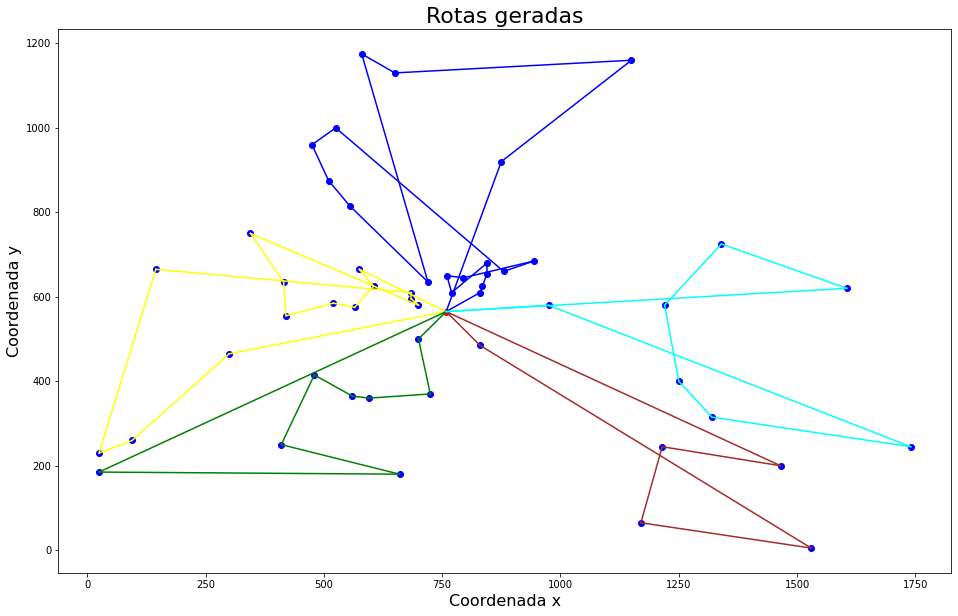

In [61]:
show_routes(delivery_places, places, depot, routes)

## Main

In [62]:
def main(filename, num_vehicles):
    
    data = extract_data(filename)
    
    delivery_places = generate_delivery_places(data)
    id_depot = len(delivery_places)
    depot = Depot(delivery_places, id_depot)
    places = delivery_places + [depot]
    
    distance_matrix = generate_distance_matrix(places)
    
    key_delivery_places, virtual_places = get_key_delivery_places(num_vehicles, delivery_places, depot)
    show_places(delivery_places, key_delivery_places, depot, virtual_places)
    
    partitions_indexes, partitions_objects = space_partition(delivery_places, key_delivery_places, depot)
    show_partition(places, partitions_indexes, depot)
    
    routes, total_distance = get_routes(partitions_indexes, partitions_objects)
    show_routes(delivery_places, places, depot, routes)

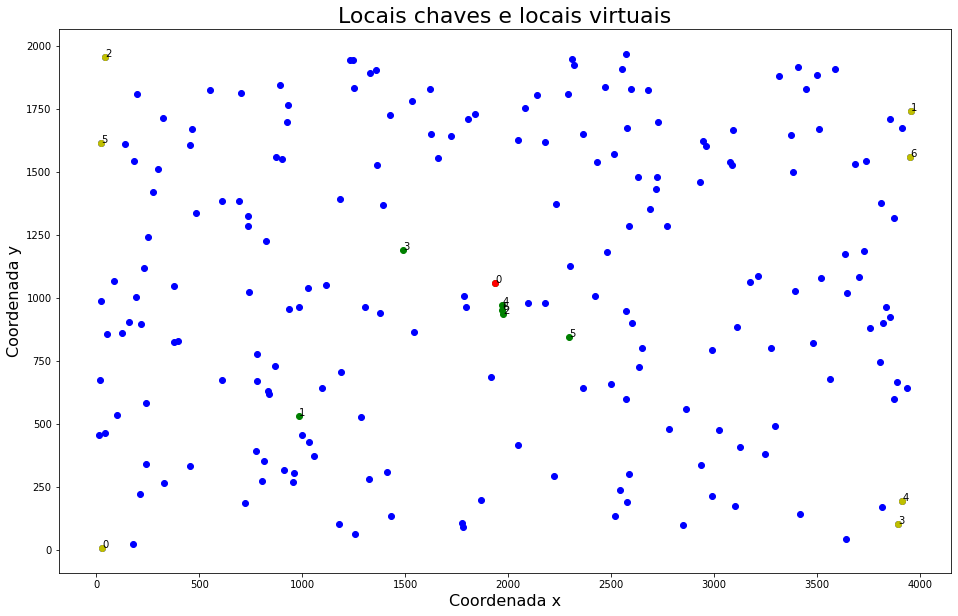

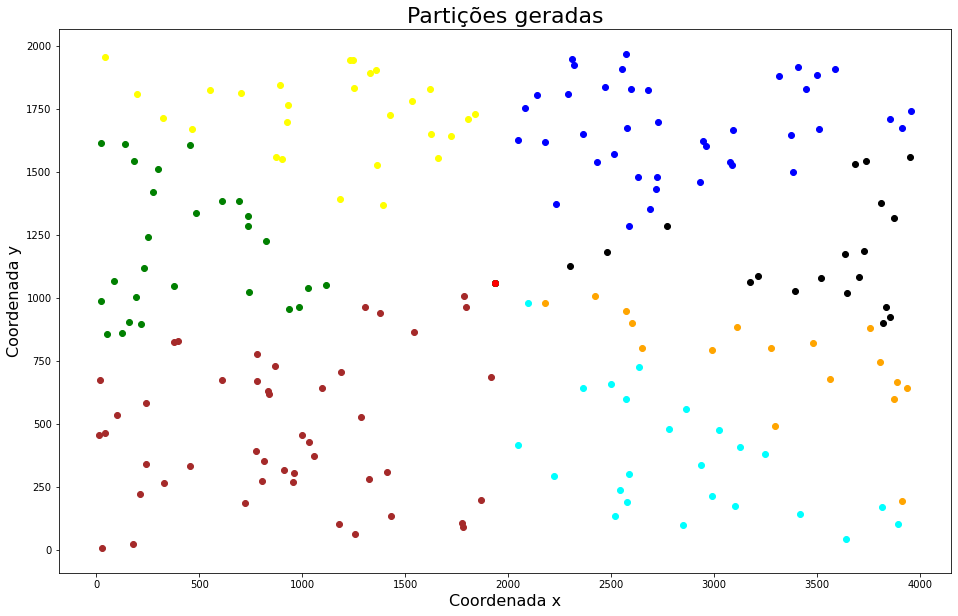

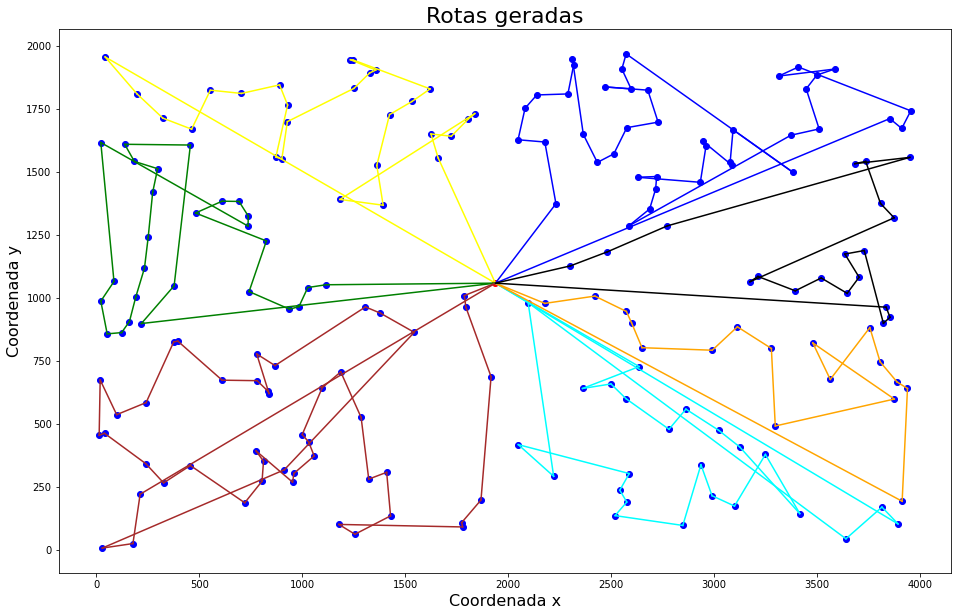

In [68]:
main('kroA200.tsp', 7)